# Analysis of Nea. ancestry

In [1]:
setwd("../../slim-neanderthal/notebooks/")

In [2]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../R/utils.R")

})

In [3]:
load_samples <- function () 
{
    suppressMessages({
        sgdp <- load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>% 
            select(-Country, pop = Region) %>% mutate(age = 0, name = fix_name(name)) %>% 
            group_by(name, age, pop) %>% summarise(Latitude = mean(Latitude), 
            Longitude = mean(Longitude)) %>% ungroup
        emhs <- read_delim("../clean_data/emh_ages.txt", delim = " ", 
            col_names = c("name", "age")) %>% mutate(pop = "EMH", 
            Latitude = NA, Longitude = NA) %>% filter(name != 
            "Oase1")
    })
    samples <- bind_rows(emhs, sgdp) %>% select(-Latitude, -Longitude)
    samples
}

In [4]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

## Calculate "direct" estimate of Nea. ancestry (on admixture array sites)

In [5]:
suppressMessages(
array_snps <- load_dataset("../clean_data/ice_age.tsv",
                           "../clean_data/sgdp.tsv",
                           "../clean_data/archaics.tsv",
                           filter_damage=TRUE,
                           random_sample=TRUE)
)

# list of samples with different library prep
non_udg_samples <- c("") #c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha)) %>%
    mutate(method="direct")

Warning message:
“Unknown variables: ``”

In [6]:
snp_counts_direct <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { sum(!is.na(ind)) }) %>% 
    gather(name, snp_count) %>% 
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

Warning message:
“Unknown variables: ``”

## Nea ancestry proportion in Africans

In [7]:
inner_join(samples, direct_nea) %>% filter(pop == "Africa") %>% arrange(desc(alpha)) %>%
mutate(name=factor(name, levels=name[order(alpha)])) %>% arrange(alpha) %>% head

Joining, by = "name"


name,age,pop,alpha,method
Yoruba,0,Africa,0.002642239,direct
Esan,0,Africa,0.002744588,direct
Mandenka,0,Africa,0.003187803,direct
Gambian,0,Africa,0.003350030,direct
Dinka,0,Africa,0.003547221,direct
Mende,0,Africa,0.003757206,direct


Joining, by = "name"


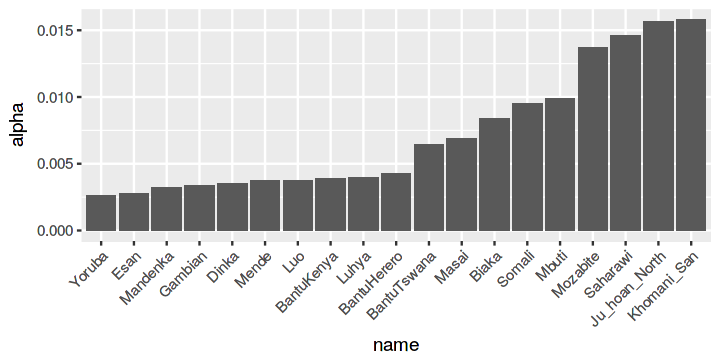

In [8]:
options(repr.plot.width=6, repr.plot.height=3)

inner_join(samples, direct_nea) %>% filter(pop == "Africa") %>% arrange(desc(alpha)) %>%
mutate(name=factor(name, levels=name[order(alpha)])) %>% 
ggplot(aes(name, alpha)) + geom_bar(stat="identity") + theme(axis.text.x=element_text(angle=45, hjust=1))

In [9]:
samples %<>% filter(!pop %in% c("Africa", "Oceania"))

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [10]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den.transitions.snp")

### Calculate the number of SNPs available for each sample on the 2.2M array

In [11]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

### Generate a table of SNPs to filter out (transitions)

In [12]:
read_fwf(SNP_FILE,
         fwf_widths(c(20, 6, 16, 16, 2, 2),
                    col_names=c("id", "chrom", "gen", "pos", "alt", "ref")),
         progress=FALSE) %>%
    keep_transitions %>%
    filter(chrom %in% 1:22) %>%
    write_tsv(BADSNP_FILE, col_names=FALSE)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)


In [13]:
dir.create("../admixtools")
setwd("../admixtools")

Warning message in dir.create("../admixtools"):
“'../admixtools' already exists”

<br><br><br><br><br><br><br><br>
# Introduction
## A Tale of <del>Two</del> $N$ Neanderthal estimates, $N \in \{2, ..., \infty\}$


### Neanderthal estimates calculated on the archaic admixture array
![](img/decline_admixture_array.png)

Calculated simply as a proportion of alleles in an individual X that match a Neanderthal allele on biallelic sites at which:

* high-coverage Altai and Vindija genomes are homozygous for one allele,
* YRI population from 1000 GP phase I has a high frequency of the second allele (> 95%).

### Neanderthal estimates based on ratios of f4 statistics
![](img/decline_f4_ice_age.png)

Calculated on a combination of arrays, collectively called the 2.2M sites array:

![](img/2.2Marray.png)

Affymetrix Human Origins Array contains 11 different sets of SNPs, each ascertained on the basis of being heterozygous in a single genome sequence from each of the 11 different populations.

<br><br><br><br><br><br><br><br>
# Calculations of Nea ancestry estimate

## Nea. ancestry proportions using David's f4 ratio

![](img/mailund_f4_tree.png)

* A - West and Central Africans
* B - Dinka
* C - new_Altai
* O - Chimp


![](img/ice_age_f4_description.png)

In [14]:
merge_pops(IND_FILE, paste0(IND_FILE, ".IceAge"),
           merge=list(West_and_Central_Africans=c("Yoruba", "Mbuti", "Mende"),
                      Nea=c("new_Altai", "new_Vindija")))

In [15]:
my_iceage_Nea <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Nea", C="Dinka", O="Chimp",
                       prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".IceAge"))

# Our new f4 ratio estimate

More straightforward & should be measuring what we _really_ want to measure:

![](img/mailund_f4_tree.png)

* A - new_Altai
* B - Vindija
* C - African
* O - Chimp

In [16]:
mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)
yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT)
dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [17]:
fu_den  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="new_Denisova", prefix=EIGENSTRAT)

Ben Peter's suggestion - should give the same results.

In [18]:
den_vi  <- qpF4ratio(X=samples$name, A="new_Denisova", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)

In [19]:
options(repr.plot.width=9, repr.plot.height=5)

### Merge all f4 results:

In [20]:
results <- bind_rows(list(my_iceage_Nea,
                          mbuti,
                          yoruba,
                          dinka,
                          fu_den,
                          den_vi)) %>% mutate(name=X, method=setup)

In [21]:
table(results$method)


        qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp 
                                                 151 
        qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp 
                                                 151 
 qpF4ratio__new_Altai_new_Vindija_Mbuti_new_Denisova 
                                                 151 
       qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp 
                                                 151 
     qpF4ratio__new_Denisova_new_Vindija_Mbuti_Chimp 
                                                 151 
qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp 
                                                 151 

# Plot Nea. estimates over time

So far we have been focusing on evaluating various scenarios of selection that could reproduce the decrease in Neanderthal ancestry that we reported in the Ice Age paper [@fu_genetic_2016]. As a reminder, this is the slope of Neanderthal ancestry form the paper that we are trying to fit:

In [22]:
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

# combine tables with both estimates into a single table for comparison and merge
# them with counts of SNPs per sample on both admixture array and 2.2M sites arrays
all_nea_estimates <- inner_join(samples, bind_rows(mutate(inner_join(direct_nea, snp_counts_direct), Zscore = Inf),
                                               inner_join(results, snp_counts_f4))) %>%
    select(name, age, pop, alpha, method, snp_count, Zscore) %>% 
    mutate(se=alpha/Zscore)

Joining, by = "name"
Joining, by = "name"
Joining, by = "name"


In [23]:
nea_estimates <- all_nea_estimates %>% 
    filter(pop %in% c("EMH", "WestEurasia"),
                      !name %in% c("BedouinB", "Druze", "Iranian", "Iraqi_Jew",
                                   "Jordanian", "Palestinian", "Samaritan", "Turkish", "Yemenite_Jew"),
                      !name %in% non_udg_samples)

In [24]:
nea_estimates %>% filter(name == "UstIshim")

name,age,pop,alpha,method,snp_count,Zscore,se
UstIshim,45020,EMH,0.02815677,direct,157653,Inf,0.000000000
UstIshim,45020,EMH,0.04529900,qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp,1637960,9.517,0.004759798
UstIshim,45020,EMH,0.02286200,qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp,1637960,5.775,0.003958788
UstIshim,45020,EMH,0.02670900,qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp,1637960,6.854,0.003896849
UstIshim,45020,EMH,0.02532600,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,1637960,6.681,0.003790750
UstIshim,45020,EMH,0.03047500,qpF4ratio__new_Altai_new_Vindija_Mbuti_new_Denisova,1637960,6.160,0.004947240
UstIshim,45020,EMH,0.00840100,qpF4ratio__new_Denisova_new_Vindija_Mbuti_Chimp,1637960,0.983,0.008546287


In [25]:
plot_nea_vs_time <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=-Inf, ylim=c(0, 0.1), plot_ci=TRUE) {
    x <- if (plot_ci) 1.96 else 0
    filter(nea_estimates,
           method == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>% {(
    ggplot(., aes(age, alpha)) +
        geom_point(aes(size=snp_count, color=abs(Zscore) > 3), alpha=3/4) +
        geom_errorbar(aes(ymin=alpha - x * se, ymax=alpha + x * se, color=abs(Zscore) > 3)) +
        geom_smooth(aes(weight=snp_count), data=filter(., abs(Zscore) > 3), method="lm", linetype=2, fullrange=TRUE, size=0.5) +
        xlim(47000, 0) + ylim(ylim[1], ylim[2]) +
        ggtitle(paste0("analysis setup: ", m))
    )}
}

run_lm <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=0) {
    filter(nea_estimates,
           method == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>%
    { lm(.[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]]) } %>% 
    summary
}

## Results from the Ice Age paper

In [26]:
options(repr.plot.width=9, repr.plot.height=5)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-3444290   -91668   517180  1042930  2517816 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -62549      18494  -3.382 0.004469 ** 
.[["alpha"]]  3684779     737352   4.997 0.000195 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1563000 on 14 degrees of freedom
Multiple R-squared:  0.6408,	Adjusted R-squared:  0.6151 
F-statistic: 24.97 on 1 and 14 DF,  p-value: 0.0001955


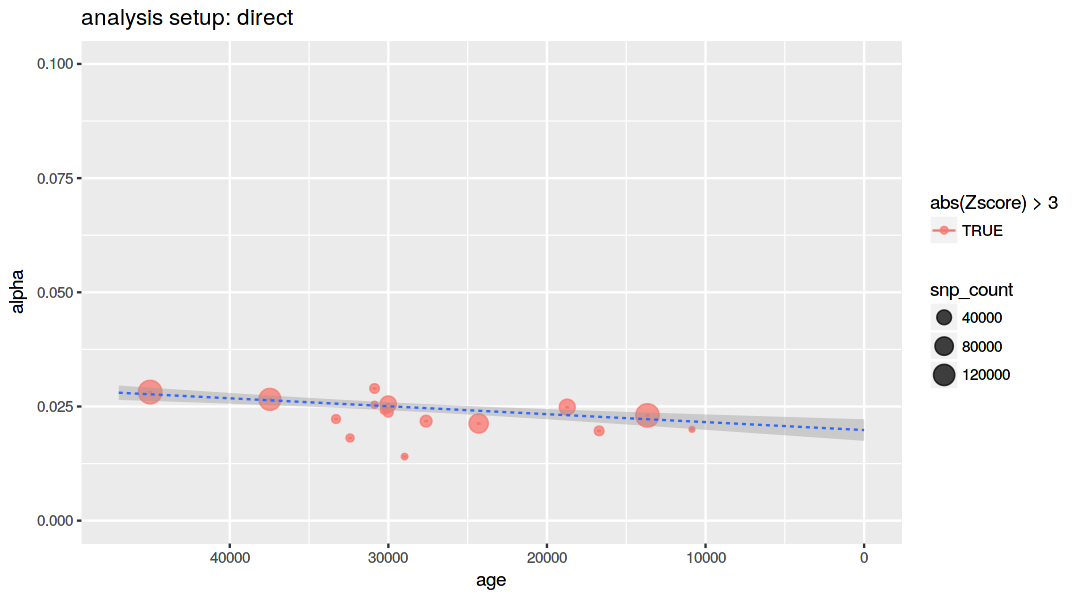

In [27]:
plot_nea_vs_time("direct", youngest=10000)
run_lm("direct", youngest=10000)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-3220484  -722884   313569  1438430  4569472 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -65763       6115  -10.76 5.07e-14 ***
.[["alpha"]]  3525765     317654   11.10 1.79e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2021000 on 45 degrees of freedom
Multiple R-squared:  0.7325,	Adjusted R-squared:  0.7265 
F-statistic: 123.2 on 1 and 45 DF,  p-value: 1.793e-14


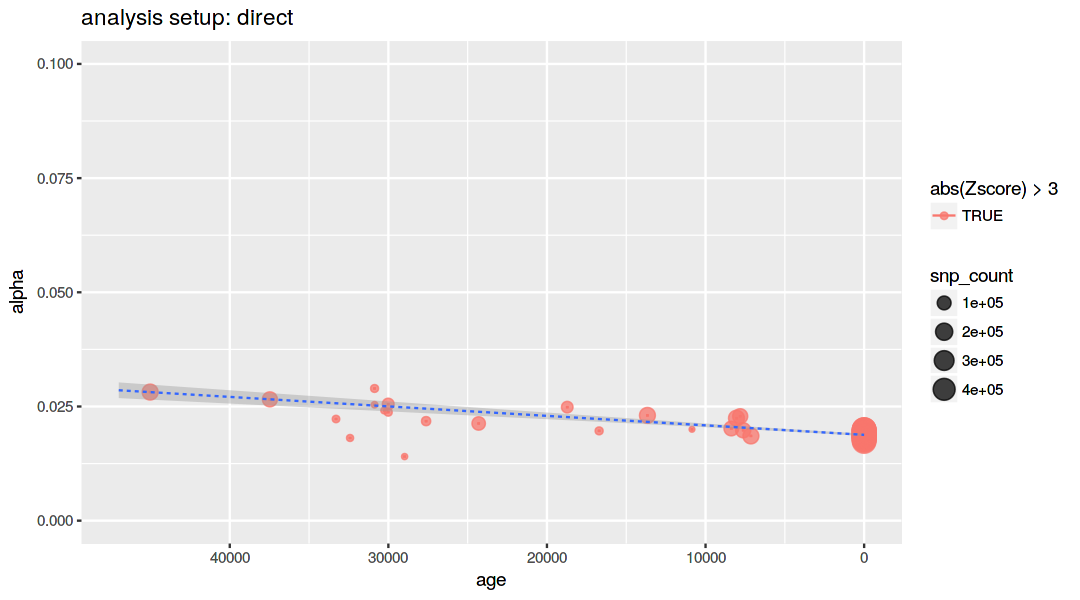

In [28]:
plot_nea_vs_time("direct")
run_lm("direct")

<font color="red">Note that we are actually showing 95% CI instead of just std errors, which are pretty meaningless by themselves (and are actually misleading, because they are small).</font>

Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 24 rows containing missing values (geom_errorbar).”

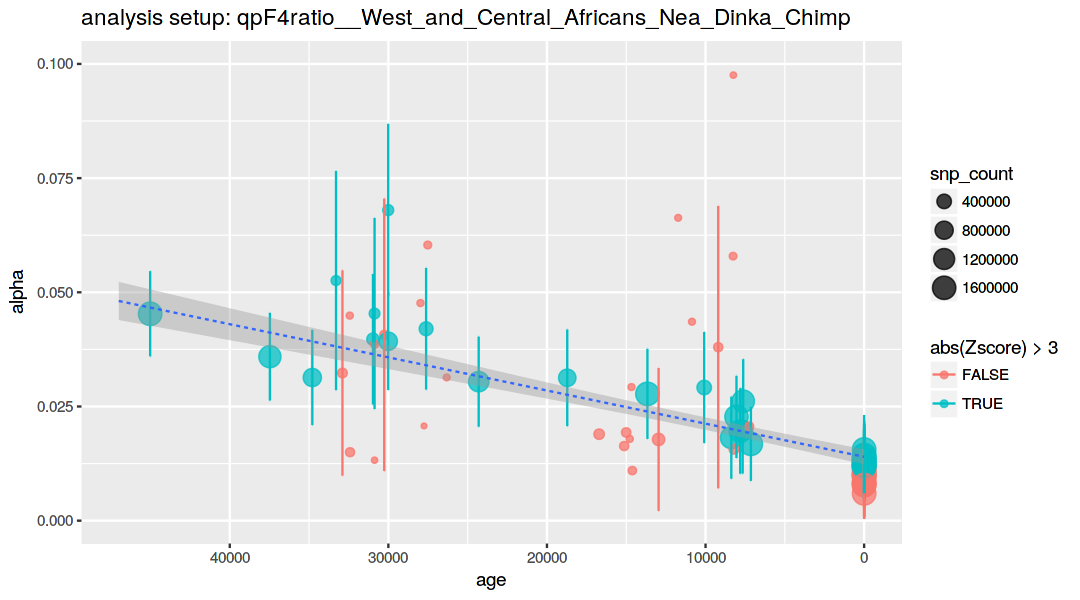

In [29]:
plot_nea_vs_time("qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp", ylim=c(0, 0.1))

# New f4 results

In [30]:
options(repr.plot.width=9, repr.plot.height=5)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-7743579 -7355544  1183698  3446113 49935691 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      4543       9070   0.501    0.618
.[["alpha"]]    63850     428639   0.149    0.882

Residual standard error: 10630000 on 70 degrees of freedom
Multiple R-squared:  0.0003169,	Adjusted R-squared:  -0.01396 
F-statistic: 0.02219 on 1 and 70 DF,  p-value: 0.882


Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 22 rows containing missing values (geom_errorbar).”

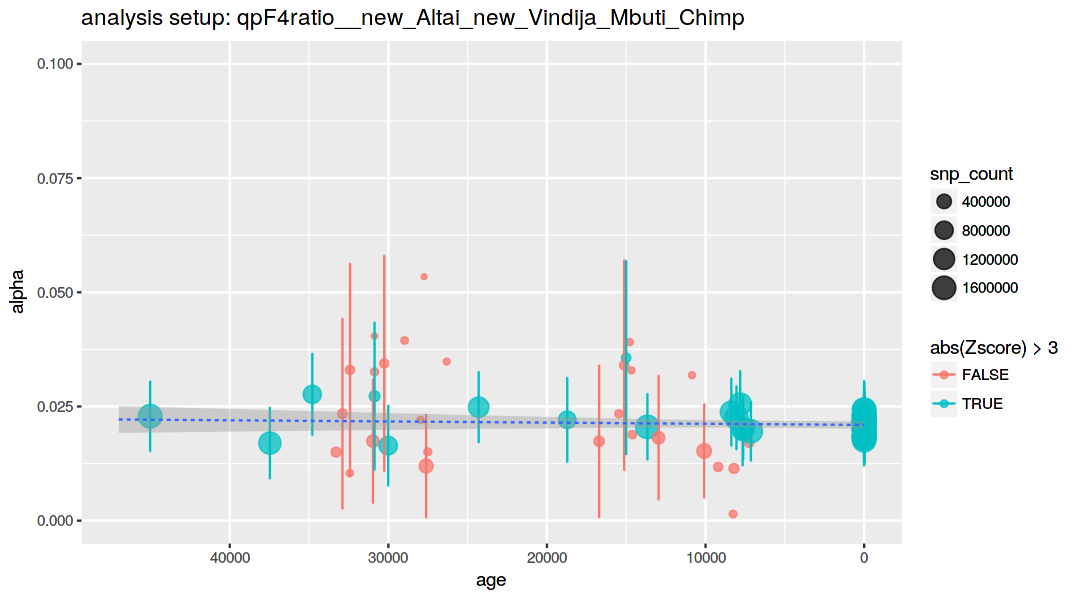

In [31]:
run_lm("qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp")


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-9600342 -6533917   838429  3675617 48931867 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)     -6594       9941  -0.663    0.509
.[["alpha"]]   528348     417252   1.266    0.210

Residual standard error: 10520000 on 70 degrees of freedom
Multiple R-squared:  0.02239,	Adjusted R-squared:  0.008427 
F-statistic: 1.603 on 1 and 70 DF,  p-value: 0.2096


Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 17 rows containing missing values (geom_errorbar).”

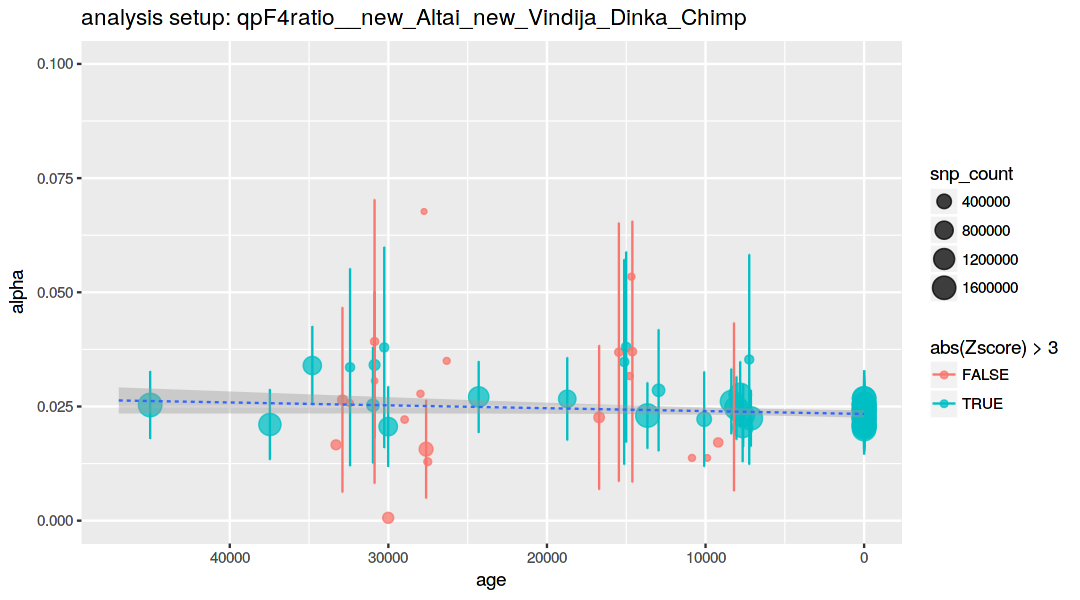

In [32]:
run_lm("qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp")


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-7552219 -7498003  1181812  3389148 50073364 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      5680      10590   0.536    0.593
.[["alpha"]]     8035     425791   0.019    0.985

Residual standard error: 10640000 on 70 degrees of freedom
Multiple R-squared:  5.088e-06,	Adjusted R-squared:  -0.01428 
F-statistic: 0.0003561 on 1 and 70 DF,  p-value: 0.985


Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 18 rows containing missing values (geom_errorbar).”

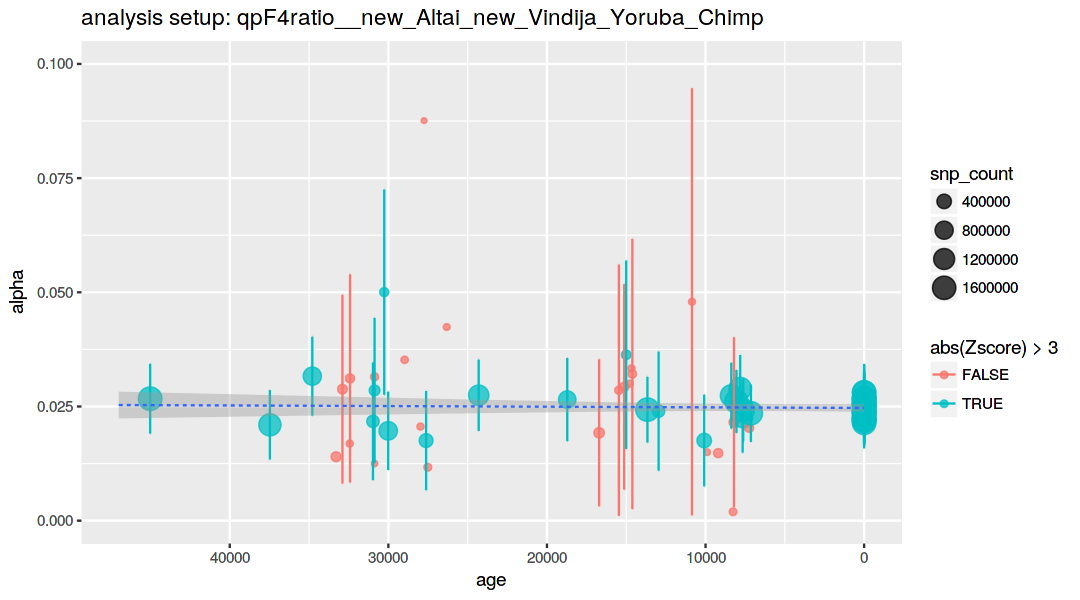

In [33]:
run_lm("qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp")

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 18 rows containing missing values (geom_errorbar).”


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-14031936  -4634450     10712   2952227  44922442 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)    -19658       8103  -2.426  0.01785 * 
.[["alpha"]]   970540     304154   3.191  0.00212 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9938000 on 70 degrees of freedom
Multiple R-squared:  0.127,	Adjusted R-squared:  0.1145 
F-statistic: 10.18 on 1 and 70 DF,  p-value: 0.002124


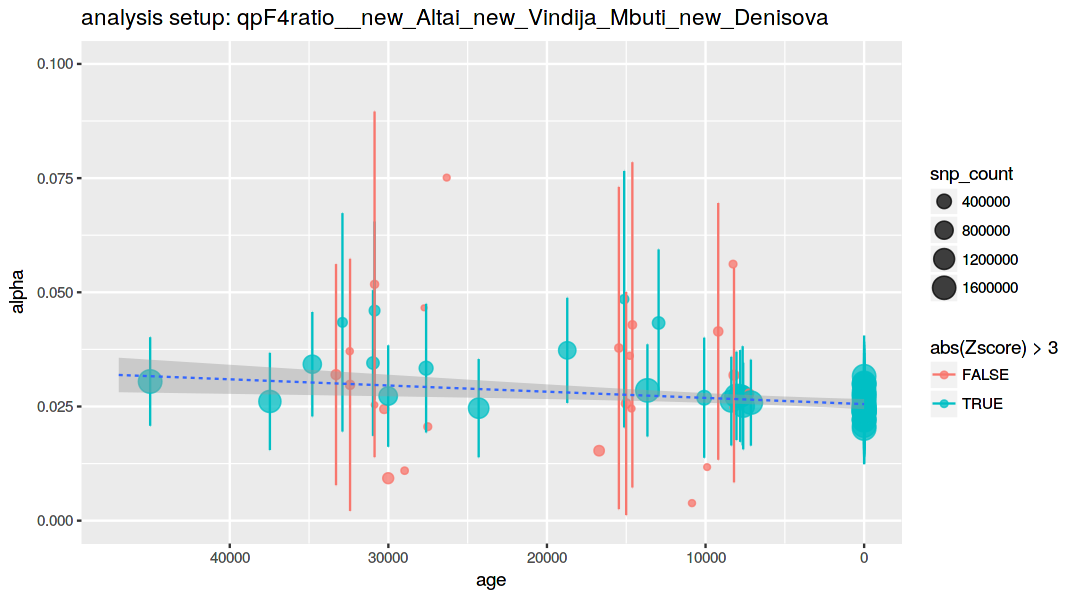

In [34]:
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Mbuti_new_Denisova")
run_lm("qpF4ratio__new_Altai_new_Vindija_Mbuti_new_Denisova")

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 18 rows containing missing values (geom_errorbar).”


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-13138455  -3687193   -151159   2295650  32237365 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      4878      10064   0.485    0.630
.[["alpha"]]   490653     347884   1.410    0.165

Residual standard error: 8434000 on 44 degrees of freedom
Multiple R-squared:  0.04325,	Adjusted R-squared:  0.02151 
F-statistic: 1.989 on 1 and 44 DF,  p-value: 0.1655


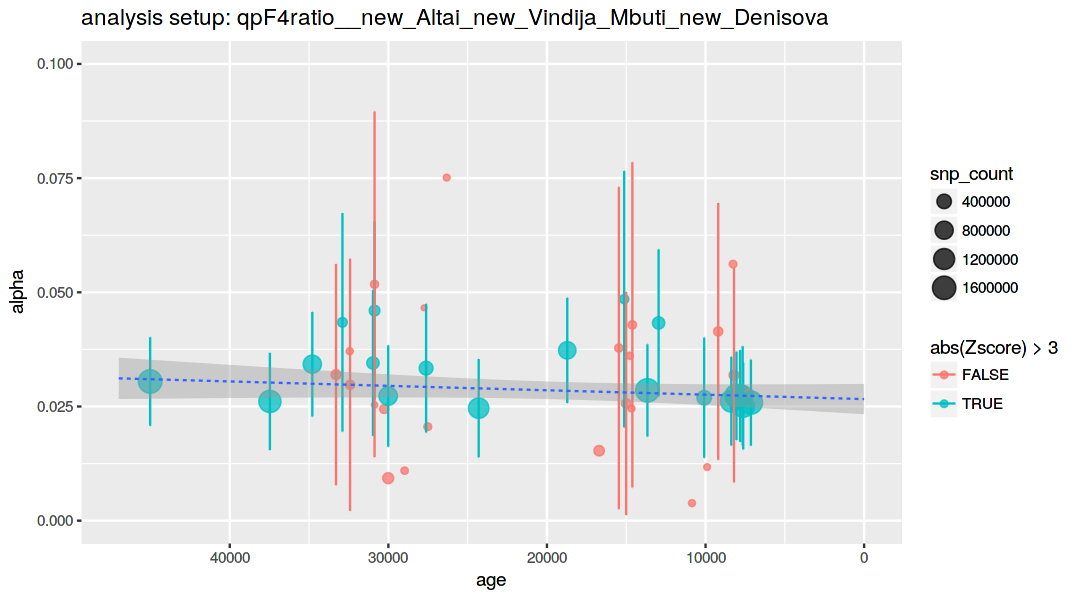

In [38]:
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Mbuti_new_Denisova", youngest=1)
run_lm("qpF4ratio__new_Altai_new_Vindija_Mbuti_new_Denisova", youngest=1)

Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 29 rows containing missing values (geom_errorbar).”

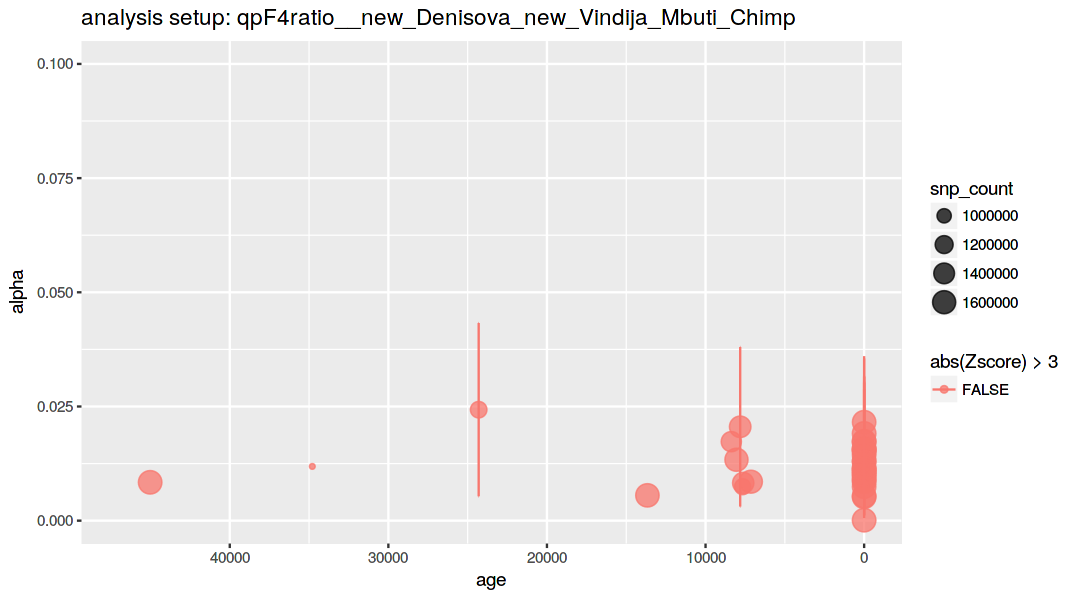

In [36]:
plot_nea_vs_time("qpF4ratio__new_Denisova_new_Vindija_Mbuti_Chimp", snp_cutoff = 800000)

In [37]:
save.image("../../nea-over-time/data/RData/admixtools_nea_ancestry.RData")